# Project1 PNLF Postproduction <a class="tocSkip">
    
After running the production notebook, this notebook can be used to create shared plots for the galaxies and LaTeX output tables

## Preparation
     
First we load a bunch of common packages that are used across the project. More specific packages that are only used in one section are loaded later to make it clear where they belong to (this also applies to all custom moduls that were written for this project).

In [1]:
# reload modules after they have been modified
%load_ext autoreload
%autoreload 2

from pnlf.packages import *

from pnlf.constants import tab10, single_column, two_column

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

we use the `logging` module to handle informations and warnings (this does not always work as expected in jupyter notebooks).

In [2]:
logging.basicConfig(stream=sys.stdout,format='%(levelname)s: %(message)s',level=logging.INFO)
logger = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

In [47]:
# first we need to specify the path to the raw data
basedir = Path('..')
data_raw = basedir / 'data' / 'raw' / 'MUSE' / 'DR2'

with open(basedir / 'data' / 'interim' / 'parameters.yml') as yml_file:
    parameters = yaml.load(yml_file,Loader=yaml.FullLoader)
    
results = ascii.read(basedir/'data'/'interim'/ 'results.txt',format='fixed_width_two_line',delimiter_pad=' ',position_char='=')
results.add_index('name')
#results.rename_columns(['(m-M)','err+(m-M)','err-(m-M)','mu_SNR','mu_SNR+','mu_SNR-'],['dis','dis_plus','dis_minus','dis_SNR','dis_SNR_plus','dis_SNR_minus'])

with open(basedir / 'data' / 'interim' / 'parameters.yml') as yml_file:
    parameters = yaml.load(yml_file,Loader=yaml.FullLoader)    

## LaTeX sample table

In [ ]:
from pnlf.auxiliary import search_table

def area(dic):
    '''Calculate the area in an image
    
    from the number of pixels and the distance,
    corrected for inclination
    '''
    
    size_of_pixel = 0.2*u.arcsec

    distance = Distance(distmod=dic['mu'])
    pixel_area = (size_of_pixel/u.arcsec * distance/206265)**2
        
    return pixel_area.to(u.kpc**2) *dic['Npixel'] / np.cos(dic['inclination']*u.deg)


filename = basedir / 'data' / 'external' / 'phangs_sample_table_v1p5.fits'
with fits.open(filename) as hdul:
    sample_table = Table(hdul[1].data)

#galaxies = sample_table[sample_table['HAS_MUSE']==1]['NAME']
galaxies = sample_table[sample_table['survey_muse_status']!='not_in_survey']['name']

latexdict = {'tabletype': 'table*',
'header_start': '\\toprule\\toprule',
'header_end': '\\midrule',
'data_end': '\\bottomrule',
'caption': f'Galaxy sample',
'units': {'R.A.':'(J2000)','Dec.':'(J2000)','Inclination':'deg','Distance':'$\si{\mega\parsec}$',
          'Survey Area':'$\si{\square\kilo\parsec}$'},
'preamble': '\\centering',
'tablefoot': f'\\label{{tbl:sample}}'
            }
 
sample_dict = {
'Name': [],
'Type':[],
'R.A.': [],
'Dec.': [],
'Distance': [],
'Inclination': [],
'posang': [],
'r25': [],
'mass': [],
'SFR': [],
'Survey Area': [],
'E(B-V)': [],
'AO' : []
}

    
for name in galaxies:
    stbl = search_table(sample_table,name)
    d = stbl["dist"][0]
    d_unc = stbl["dist_unc"][0]

    sample_dict['Type'].append(stbl['morph_string'])    
    sample_dict['Name'].append(name.upper())
    sample_dict['R.A.'].append(stbl['orient_ra'])
    sample_dict['Dec.'].append(stbl['orient_dec'])
    sample_dict['Distance'].append(d)
    sample_dict['Inclination'].append(stbl['orient_incl'])
    sample_dict['posang'].append(stbl['orient_posang'])
    sample_dict['r25'].append(stbl['size_r25'])
    sample_dict['mass'].append(stbl['props_mstar'])
    sample_dict['SFR'].append(stbl['props_sfr'])
    sample_dict['E(B-V)'].append(parameters[name.upper()]['Ebv'])
    if parameters[name.upper()]['power_index'] == 2.3:
        sample_dict['AO'].append('\checkmark')
    else:
        sample_dict['AO'].append('')

    try:
        sample_dict['Survey Area'].append(f'{area(parameters[name.upper()]).value:.1f}')
    except:
        sample_dict['Survey Area'].append('NaN')
    '''
    sample_dict['Name'].append(name)
    sample_dict['R.A.'].append(stbl['ORIENT_RA'])
    sample_dict['Dec.'].append(stbl['ORIENT_DEC'])
    sample_dict['Distance'].append(stbl['DIST'])
    sample_dict['Inclination'].append(stbl['ORIENT_INCL'])
    sample_dict['$\log_{10}(M_*)$'].append(stbl['MSTAR_LOGMSTAR'])
    sample_dict['$\log_{10}($SFR$)$'].append(stbl['SFR_LOGSFR'])
    '''

sample = Table(sample_dict)
sample['mass'] = np.log10(sample['mass'])
sample['SFR'] = np.log10(sample['SFR'])
sample['mass'].info.format = '%.2f' 
sample['SFR'].info.format = '%.2f' 
coord = SkyCoord(sample['R.A.']*u.degree,sample['Dec.']*u.degree)
sample['R.A.'], sample['Dec.'] = zip(*[x[0].split(' ') for x in coord.to_string(style='hmsdms',precision=2)])
#sample.add_column('',index=1,name='Type')

In [ ]:
with open(basedir / 'data' / 'interim' / 'sample.txt','w',newline='\n') as f:
    ascii.write(sample,f,format='fixed_width_two_line',overwrite=True,delimiter_pad=' ',position_char='=')
    
sample.rename_columns(['mass','SFR'],['$\log_{10}(M_*/\si{\Msun})$','$\log_{10}($SFR$/\si{\Msun \per \year})$'])
sample.remove_columns(['r25','Survey Area'])
with open(basedir / 'data' / 'interim' /'sample.tex','w',newline='\n') as f:
    ascii.write(sample,f,Writer=ascii.Latex, latexdict=latexdict,overwrite=True)
    
#sample

## LaTeX result table

this uses the result table and prints out a LaTeX table (only the data part) that can be used in the final document. In another step, we merge the individual catalogues for PN and SNR identifications. 

In [12]:
results['dis_Mpc'] = Distance(distmod=results['(m-M)']).to(u.Mpc)
results['dis_Mpc_plus'] = (Distance(distmod=results['(m-M)']+results['err+(m-M)']) - results['dis_Mpc']).to(u.Mpc)
results['dis_Mpc_minus'] = (results['dis_Mpc']-Distance(distmod=results['(m-M)']-results['err-(m-M)'])).to(u.Mpc)

#results['dis_SNR_Mpc'] = (Distance(distmod=results['dis_SNR'])).to(u.Mpc)
#results['dis_SNR_Mpc_plus'] = (Distance(distmod=results['dis_SNR']+results['dis_SNR_plus']) - results['dis_SNR_Mpc']).to(u.Mpc)
#results['dis_SNR_Mpc_minus'] = (results['dis_SNR_Mpc']-Distance(distmod=results['dis_SNR']-results['dis_SNR_minus'])).to(u.Mpc)

In [13]:
# save to file
for col in ['(m-M)','err+(m-M)','err-(m-M)','dis_Mpc','dis_Mpc_plus','dis_Mpc_minus']:
    results[col].info.format = '%.2f'

distance_modulus = []
distance_parsec = []
for row in results:
    distance_modulus.append(f'{row["(m-M)"]:.2f} + {row["err-(m-M)"]:.2f} - {row["err+(m-M)"]:.2f}')
    distance_parsec.append(f'{row["dis_Mpc"]:.2f} + {row["dis_Mpc_plus"]:.2f} - {row["dis_Mpc_plus"]:.2f}')
results['mu'] = distance_modulus
results['d/Mpc'] = distance_parsec
                           
filename = basedir / 'data' / 'interim' / f'distances.txt'
with open(filename,'w',newline='\n') as f:
    ascii.write(results[['name','mu','d/Mpc']],
                f,format='fixed_width',delimiter='\t',overwrite=True)

In [14]:
tbl_out = ''
results.sort('name')
for row in results:
    tbl_out += f'{row["name"]} & {row["N_PN"]} & {row["N_SNR"]} ({row["N_SNRorPN"]}) '
    tbl_out += f'& $\\uncertainty{{{row["(m-M)"]:.2f}}}{{{row["err+(m-M)"]:.2f}}}{{{row["err-(m-M)"]:.2f}}}$ '
    tbl_out += f'& $\\uncertainty{{{row["dis_Mpc"]:.2f}}}{{{row["dis_Mpc_plus"]:.2f}}}{{{row["dis_Mpc_minus"]:.2f}}}$ '
    tbl_out += f'& {row["alpha"]:.2f}\\\\\n'
    #tbl_out += f'& $\\uncertainty{{{row["dis_SNR"]:.2f}}}{{{row["dis_SNR_plus"]:.2f}}}{{{row["dis_SNR_minus"]:.2f}}}$ '
    #tbl_out += f'& $\\uncertainty{{{row["dis_SNR_Mpc"]:.2f}}}{{{row["dis_SNR_Mpc_plus"]:.2f}}}{{{row["dis_SNR_Mpc_minus"]:.2f}}}$\\\\\n'
    
    
print(tbl_out)    

IC5332 & 49 & 55 (18) & $\uncertainty{29.75}{0.05}{0.21}$ & $\uncertainty{8.91}{0.20}{0.81}$ & -7.78\\
NGC0628 & 148 & 89 (13) & $\uncertainty{29.96}{0.07}{0.11}$ & $\uncertainty{9.84}{0.32}{0.47}$ & -8.00\\
NGC1087 & 6 & 31 (3) & $\uncertainty{31.58}{0.05}{0.30}$ & $\uncertainty{20.67}{0.52}{2.68}$ & -8.87\\
NGC1300 & 16 & 51 (7) & $\uncertainty{32.13}{0.08}{0.11}$ & $\uncertainty{26.67}{0.98}{1.29}$ & -8.12\\
NGC1365 & 16 & 72 (0) & $\uncertainty{31.57}{0.08}{0.19}$ & $\uncertainty{20.63}{0.80}{1.69}$ & -8.85\\
NGC1385 & 20 & 47 (4) & $\uncertainty{31.04}{0.04}{0.21}$ & $\uncertainty{16.11}{0.27}{1.47}$ & -7.84\\
NGC1433 & 83 & 72 (5) & $\uncertainty{31.35}{0.04}{0.07}$ & $\uncertainty{18.63}{0.36}{0.58}$ & -8.15\\
NGC1512 & 30 & 71 (21) & $\uncertainty{31.37}{0.05}{0.13}$ & $\uncertainty{18.83}{0.47}{1.12}$ & -8.38\\
NGC1566 & 24 & 92 (5) & $\uncertainty{31.13}{0.09}{0.20}$ & $\uncertainty{16.83}{0.71}{1.47}$ & -8.73\\
NGC1672 & 23 & 71 (4) & $\uncertainty{30.94}{0.10}{0.26}$ & $\un

In [33]:
tbl_out = ''
results.sort('name')
for row in results:
    print(f'\\setvalue{{mag/{row["name"]} =\\SI{{\\uncertainty{{{row["(m-M)"]:.2f}}}{{{row["err+(m-M)"]:.2f}}}{{{row["err-(m-M)"]:.2f}}}}}{{\\mag}}}}')
print(' ')
for row in results:
    print(f'\\setvalue{{Mpc/{row["name"]} =\\SI{{\\uncertainty{{{row["dis_Mpc"]:.2f}}}{{{row["dis_Mpc_plus"]:.2f}}}{{{row["dis_Mpc_minus"]:.2f}}}}}{{\\mega\\parsec}}}}')
    

\setvalue{mag/IC5332 =\SI{\uncertainty{29.75}{0.05}{0.21}}{\mag}}
\setvalue{mag/NGC0628 =\SI{\uncertainty{29.96}{0.07}{0.11}}{\mag}}
\setvalue{mag/NGC1087 =\SI{\uncertainty{31.58}{0.05}{0.30}}{\mag}}
\setvalue{mag/NGC1300 =\SI{\uncertainty{32.13}{0.08}{0.11}}{\mag}}
\setvalue{mag/NGC1365 =\SI{\uncertainty{31.57}{0.08}{0.19}}{\mag}}
\setvalue{mag/NGC1385 =\SI{\uncertainty{31.04}{0.04}{0.21}}{\mag}}
\setvalue{mag/NGC1433 =\SI{\uncertainty{31.35}{0.04}{0.07}}{\mag}}
\setvalue{mag/NGC1512 =\SI{\uncertainty{31.37}{0.05}{0.13}}{\mag}}
\setvalue{mag/NGC1566 =\SI{\uncertainty{31.13}{0.09}{0.20}}{\mag}}
\setvalue{mag/NGC1672 =\SI{\uncertainty{30.94}{0.10}{0.26}}{\mag}}
\setvalue{mag/NGC2835 =\SI{\uncertainty{30.53}{0.05}{0.19}}{\mag}}
\setvalue{mag/NGC3351 =\SI{\uncertainty{30.27}{0.04}{0.10}}{\mag}}
\setvalue{mag/NGC3627 =\SI{\uncertainty{30.23}{0.08}{0.17}}{\mag}}
\setvalue{mag/NGC4254 =\SI{\uncertainty{30.82}{0.05}{0.21}}{\mag}}
\setvalue{mag/NGC4303 =\SI{\uncertainty{30.84}{0.07}{0.22}}{\ma

In [ ]:
tbl_lst = []
ID_lst = []
for name in results['name']:
    tmp = ascii.read(basedir/'data'/'catalogues'/f'{name}_SNR_candidates.txt',format='fixed_width_two_line')
    ID_lst += list(tmp['ID'])
    del tmp['ID']
    tbl_lst.append(tmp)
    
tbl = vstack(tbl_lst)
tbl.add_column(ID_lst,index=1,name='ID')


with open(basedir/'data'/'catalogues'/'SNR_candidates.txt','w',newline='\n') as f:
    ascii.write(tbl,f,format='fixed_width_two_line',overwrite=True,delimiter_pad=' ',position_char='=')

## Combined PNLF

In [4]:
# here we define possible lists of objects to plot
DR2  = ['NGC1300','NGC1385','NGC1433','NGC4303','NGC4321','NGC7496']
good = ['IC5332','NGC0628','NGC1566','NGC3351','NGC3627','NGC5068']
PHANGS = ['NGC1300','NGC1433','NGC1512','NGC1672']
#good = ['NGC0628','NGC3627','NGC5068']
PHANGS_sample = ['IC5332','NGC1087','NGC1300','NGC1365','NGC1385','NGC1433', 'NGC1512','NGC1566','NGC1672',
                 'NGC2835','NGC3351','NGC3627','NGC4254','NGC4303','NGC4321','NGC4535','NGC5068','NGC7496']

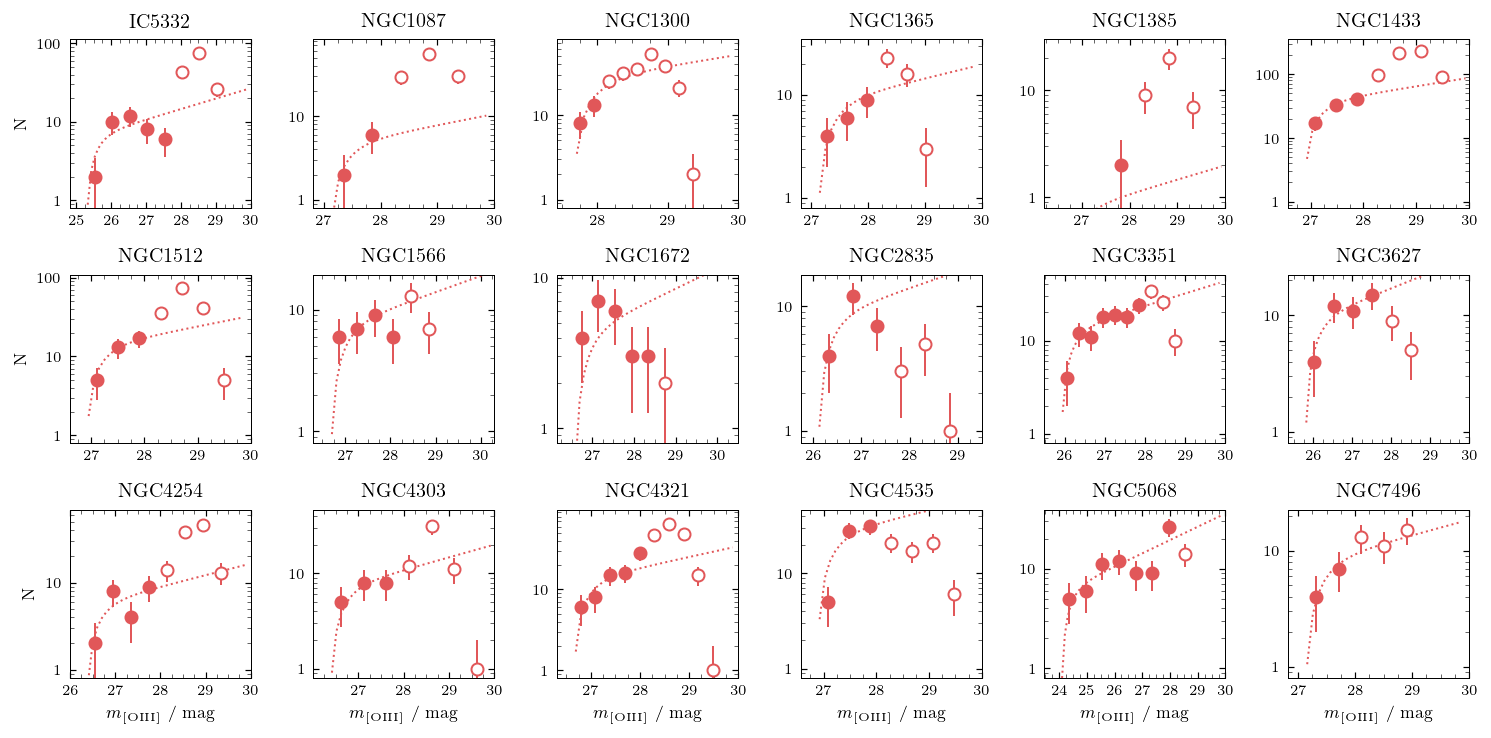

In [49]:
from pnlf.plot.pnlf import _plot_pnlf

names = PHANGS_sample
nrows = 3
ncols = 6
filename = basedir / 'reports' / f'all_objects1_PNLF_pres'

#----------------------------------------------
# DO NOT MODIFY BELOW
#----------------------------------------------
if nrows*ncols<len(names):
    raise ValueError('not enough subplots for selected objects') 
width = two_column*1.5
fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(width,width/ncols*nrows))
axes_iter = iter(axes.flatten())
Mmax = -4.47
    
# loop over the galaxies we want to plot
for name in names:  
    # read in the data
    catalogue_file = basedir / 'data' / 'catalogues' / f'{name}_nebulae.txt'
    if catalogue_file.is_file():
        catalogue = ascii.read(catalogue_file,format='fixed_width_two_line',delimiter_pad=' ',position_char='=')
        catalogue['exclude'] = catalogue['exclude'].astype(bool)
    else:
        print(f'no catalogue for {name}')
        continue
        
    # get the next axis and find position on the grid
    ax = next(axes_iter)
    if nrows>1 and ncols>1:
        i, j = np.where(axes == ax)
        i,j=i[0],j[0]
    elif ncols>1:
        i,j = 0, np.where(axes==ax)[0]
    elif nrows>1:
        i,j = np.where(axes==ax)[0],0
    else:
        i,j=0,0
        
    # pre-process the data for the plot and read additional parameters
    data = catalogue[(catalogue['type']=='PN') & (~catalogue['exclude'])]['mOIII']
    mu = results.loc[name]['(m-M)']
    completeness = parameters[name]['completeness_limit']
    cut = parameters[name].get('cut',0)
    if cut>0:
        print(f'warning: using cut={cut} for {name}')
    data = data[data>cut]
    binsize = parameters[name]['binsize']
    mlow = Mmax+mu
    mhigh = 30

    ax=_plot_pnlf(data,mu,completeness,binsize=binsize,ax=ax)
    #ax.set_xlim([mu-5,completeness+0.5])
    # add labels to the axis
    if i==nrows-1:
        ax.set_xlabel(r'$m_{[\mathrm{OIII}]}$ / mag')
    if j==0:
        ax.set_ylabel(r'N')
    ax.set_title(name)
    
h,l = fig.axes[0].get_legend_handles_labels()
#fig.legend(h, l, bbox_to_anchor=(0., 1.01, 1., .051),loc = 'upper center',ncol=2)

plt.tight_layout()
plt.savefig(filename.with_suffix('.pdf'),bbox_inches='tight')
plt.savefig(filename.with_suffix('.png'),bbox_inches='tight',dpi=600)

plt.show()

## Combined cumulative PNLF

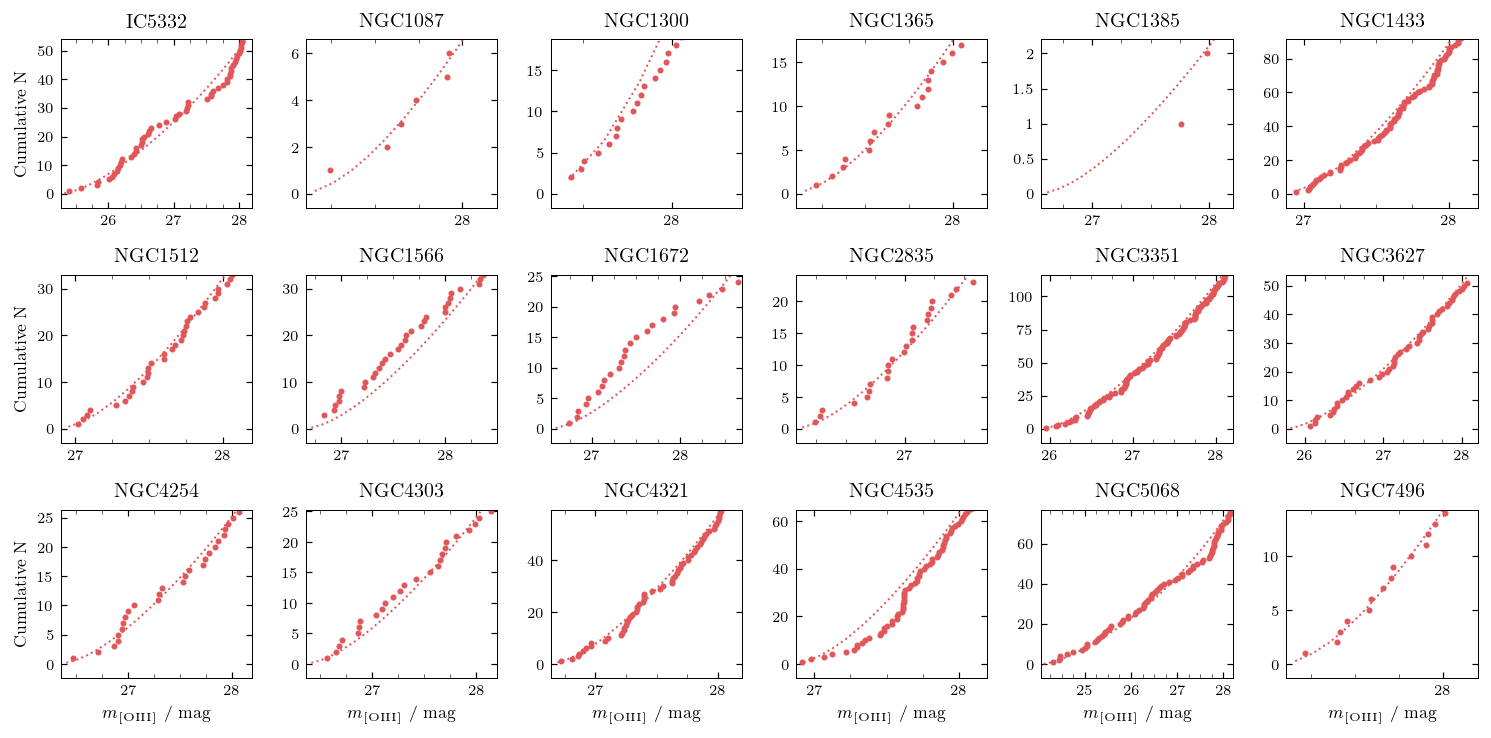

In [50]:
from pnlf.plot.pnlf import _plot_cum_pnlf

names = PHANGS_sample
nrows = 3
ncols = 6
filename = basedir / 'reports' / f'all_objects2_PNLF_cum_pres'

#----------------------------------------------
# DO NOT MODIFY BELOW
#----------------------------------------------
if nrows*ncols<len(names):
    raise ValueError('not enough subplots for selected objects')
width = 1.5*two_column
fig, axes_arr = plt.subplots(nrows=nrows,ncols=ncols,figsize=(width,width/ncols*nrows))
axes = iter(axes_arr.flatten())

binsize=0.1
Mmax = -4.47
color = 'tab:red'

for name in names:  
        
    catalogue_file = basedir / 'data' / 'catalogues' / f'{name}_nebulae.txt'
    if catalogue_file.is_file():
        catalogue = ascii.read(catalogue_file,format='fixed_width_two_line',delimiter_pad=' ',position_char='=')
        catalogue['exclude'] = catalogue['exclude'].astype(bool)
    else:
        print(f'no catalogue for {name}')
        continue
    
    # get the next axis
    ax = next(axes)
    # find current position on the grid
    i, j = np.where(axes_arr == ax)
    i,j=i[0],j[0]
    
    data = catalogue[(catalogue['type']=='PN') & (~catalogue['exclude'])]['mOIII']
    mu = results.loc[name]['(m-M)']
    completeness = parameters[name]['completeness_limit']
    cut = parameters[name].get('cut',0)
    if cut>0:
        print(f'warning: using cut={cut} for {name}')
    data = data[data>cut]
    
    ax=_plot_cum_pnlf(data,mu,completeness,ax=ax,binsize=None)
    
    # add labels to the axis
    if i==nrows-1:
        ax.set_xlabel(r'$m_{[\mathrm{OIII}]}$ / mag')
    if j==0:
        ax.set_ylabel(r'Cumulative N')
    
    ax.set_title(name)
    
plt.tight_layout()
plt.savefig(filename.with_suffix('.pdf'),bbox_inches='tight')
plt.savefig(filename.with_suffix('.png'),bbox_inches='tight',dpi=600)

plt.show()

## Combine line diagnostics

In [ ]:
from pnlf.analyse import PNLF

names = result['name']
style = {'SNR':{"marker":'o',"ms":3,"mfc":'None',"mec":tab10[0],'ls':'none','ecolor':tab10[0]},
         'SNRorPN':{"marker":'o',"ms":4,"mfc":'white',"mec":'tab:green','ls':'none','ecolor':'tab:green'},
         'HII':{"marker":'+',"ms":3,"mec":tab10[1],'ls':'none'},
         'PN':{"marker":'o',"ms":2,"mfc":'black','mec':'black','ls':'none','ecolor':'black'}
        }
Mmax=-4.47
color = 'tab:red'

# define the figure with the number of subplots
nrows = 2
ncols = 3
width = two_column
fig, axes_arr = plt.subplots(nrows=nrows,ncols=ncols,figsize=(width,width/ncols*nrows))
axes = iter(axes_arr.flatten())


names = ['IC5332','NGC0628','NGC1566','NGC3351','NGC3627','NGC5068']

# loop over the galaxies we want to plot
for name in names:  
       
    # read in the data
    catalogue_file = basedir / 'data' / 'catalogues' / f'{name}_nebulae.txt'
    if catalogue_file.is_file():
        catalogue = ascii.read(catalogue_file,format='fixed_width_two_line',delimiter_pad=' ',position_char='=')
        catalogue['exclude'] = catalogue['exclude'].astype(bool)
        for col in catalogue.columns:
            if col.endswith('detection'):
                catalogue[col] = catalogue[col]=='True'
    else:
        print(f'no catalogue for {name}')
        continue
        
    # get the next axis
    ax = next(axes)
    # find current position on the grid
    i, j = np.where(axes_arr == ax)
    i,j=i[0],j[0]
    
    # pre-process the data for the plot and read additional parameters
    mu = result.loc[name]['dis']
    completeness = parameters[name]['completeness_limit']
    
    # draw line that we use seperate PN from HII
    MOIII = np.linspace(-5,1)
    OIII_Ha = 10**(-0.37*(MOIII)-1.16)
    ax.plot(MOIII,OIII_Ha,c='black',lw=0.6)
    ax.axhline(10**4)

    if completeness:
        ax.axvline(completeness-mu,ls='--',c='grey',lw=0.5)
    ax.axvline(Mmax,ls='--',c='grey',lw=0.5)

    for t in ['HII','PN','SNR']:
        tbl = catalogue[catalogue['type']==t]        
        ax.errorbar(tbl['mOIII']-mu,tbl['OIII5006']/(tbl['HA6562']+tbl['NII6583']),**style[t],label=t) 

        if t=='PN':
            # indicate for which PN we don't have a detection in HA6562
            tbl = tbl[~tbl['HA6562_detection']]
            ax.errorbar(tbl['mOIII']-mu,1.11*tbl['OIII5006']/(tbl['HA6562']+tbl['NII6583']),
                         marker=r'$\uparrow$',ms=4,mec='black',ls='none') 
        if t=='SNR':
            #tbl = tbl[tbl['SNRorPN']] 
            ax.errorbar(tbl['mOIII']-mu,tbl['OIII5006']/(tbl['HA6562']+tbl['NII6583']), marker='x',ms=2,mec=tab10[0],ls='none') 
   
    # objects that were rejeceted by eye
    tbl = catalogue[catalogue['exclude']]
    ax.errorbar(tbl['mOIII']-mu,tbl['OIII5006']/(tbl['HA6562']+tbl['NII6583']),marker='o',ms=3,ls='none',color='tab:green',label='rejected') 
    
    
    # configure axes 
    ax.set(xlim=[-5,np.ceil(completeness-mu)],
           ylim=[0.03,200],
           yscale='log')
    
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:.16g}'.format(y)))

    axt = ax.twiny()
    xlim1,xlim2 = ax.get_xlim()
    axt.set_xticks(np.arange(np.ceil(xlim1+mu),np.floor(xlim2+mu)+1),minor=False)
    axt.set(xlim   = [xlim1+mu,xlim2+mu])
    
    if i==0:
        axt.set(xlabel = r'$m_{\mathrm{[OIII]}}$')
    
    if i==nrows-1:
        ax.set(xlabel=r'$M_{\mathrm{[OIII]}}$')
    if j==0:
        ax.set(ylabel=r'[OIII] / $(\mathrm{H}\alpha + \mathrm{[NII]})$')
    ax.set_title(name)
    
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    
    
h,l = fig.axes[0].get_legend_handles_labels()
fig.legend(h, l, bbox_to_anchor=(0., 1.01, 1., .051),loc = 'upper center',ncol=4)

plt.tight_layout()
filename = basedir / 'reports' / f'all_objects_line_diagnostics'
plt.savefig(filename.with_suffix('.pdf'),bbox_inches='tight')
plt.savefig(filename.with_suffix('.png'),bbox_inches='tight',dpi=600)

plt.show()

## Plot RGB image

In [ ]:
from pnlf.auxiliary import circular_mask
from pnlf.plot.plot import create_RGB
from pnlf.io import ReadLineMaps

nrows = 5
ncols = 4
width = two_column
fig, axes_arr = plt.subplots(nrows=nrows,ncols=ncols,figsize=(width,width/ncols*nrows))
axes = iter(axes_arr.flatten())

# loop over the galaxies we want to plot
for name in results['name']:  
        
    # get the next axis
    ax = next(axes)
    # find current position on the grid
    i, j = np.where(axes_arr == ax)
    i,j=i[0],j[0]
    
    #galaxy = galaxies[name]
    galaxy = ReadLineMaps(data_raw,name,**parameters[name])
    
    # define masks as slices
    masks = {
     'NGC1300' : circular_mask(*galaxy.shape,radius=50),
     'NGC1365' : circular_mask(*galaxy.shape,(720,420),radius=200),
     #'NGC1433' : circular_mask(*galaxy.shape,radius=100),
     'NGC1512' : circular_mask(*galaxy.shape,radius=70),
     'NGC1566' : circular_mask(*galaxy.shape,(450,450),radius=100)|circular_mask(*galaxy.shape,(350,150),radius=180),
     'NGC1672' : circular_mask(*galaxy.shape,(600,310),radius=60),
     #'NGC3627' : circular_mask(*galaxy.shape,(330,740),radius=100),
     'NGC3351' : circular_mask(*galaxy.shape,radius=200),
     'NGC4321' : circular_mask(*galaxy.shape,(550,450),radius=60),
     'NGC4535' : circular_mask(*galaxy.shape,(300,520),radius=100)
    }
    
    mask = np.zeros(galaxy.shape,dtype=bool)
    mask |= galaxy.star_mask.astype(bool)
    mask[masks.get(galaxy.name,(slice(-1,0),slice(-1,0)))] = True

    #img = galaxy.OIII5006_DAP.copy()
    img = create_RGB(galaxy.HA6562,galaxy.OIII5006_DAP,galaxy.SII6716,weights=[0.6,1,0.6],percentile=[95,99.,95])
    img[mask,...] = (1,1,1) #(1, 165/255, 1/255) 

    ax.imshow(img,origin='lower')
    ax.set_title(name)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
filename = basedir / 'reports' / f'all_objects_rgb'
plt.savefig(filename.with_suffix('.pdf'),bbox_inches='tight')
#plt.savefig(filename.with_suffix('.png'),bbox_inches='tight',dpi=600)

plt.show()

In [ ]:
from pnlf.auxiliary import mu_to_parsec, parsec_to_mu

In [ ]:
parsec_to_mu(9.01,0.38,0.38)

## Redo all distance plots

In [ ]:
from pnlf.plot.pnlf import compare_distances

name = results[14]['name']
mu,mu_m,mu_p = results.loc[name][['(m-M)','err-(m-M)','err+(m-M)']]

print(name)
filename = basedir / 'reports' / name / f'{name}_distances'
distances = compare_distances(name,mu,mu_p,mu_m,filename=filename)

## PN Number vs Mass etc.

In [ ]:
sample=ascii.read(basedir/'reports'/'sample.txt')
sample['SkyCoord'] = SkyCoord(sample['R.A.'],sample['Dec.'])
sample.add_index('Name')

In [ ]:
galaxies = {}

for n in result['name']:
    print('are you sure that you want to run this?')
    break
    filename = data_raw / 'MUSEDAP' / f'{n}_MAPS.fits'

    with fits.open(filename) as hdul:
        d=hdul['STELLAR_MASS_DENSITY'].data
        galaxies[n]= np.nansum(d)

In [ ]:
result['mass']=sample['mass']
result['Survey Area'] = sample['Survey Area']

Calculate the survey area from number of pixels and distance

In [ ]:
for row in result:
    N_pix = row['N_pixel']
    d = Distance(distmod=parameters[row['name']]['mu'])
    A_pix = ((d*(0.2/206265))**2).to(u.kpc**2)
    
    print(f'{row["name"]}: {d:.2f}, {N_pix*A_pix:.2f}')

In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(ncols=3,nrows=1,figsize=(12,4))

for row in result:
    if row['N_PN']>1:
        ax1.scatter(row['mass'],row['N_PN'])
        ax1.text(row['mass'],row['N_PN']+2,row['name'],horizontalalignment='center')
        
        
        ax2.scatter(row['Survey Area'],row['N_PN'])
        ax2.text(row['Survey Area'],row['N_PN']+2,row['name'],horizontalalignment='center') 

        ax3.scatter(row['N_pixel'],row['N_PN'])
        ax3.text(row['N_pixel'],row['N_PN']+2,row['name'],horizontalalignment='center') 
        

ax1.set(xlabel='stellar mass density',ylabel='N PN')
ax2.set(xlabel='Survey Area')
ax3.set(xlabel='Npixel')
#ax3.set(xlabel='Npixel')
plt.show()

## Other PNLF studies

In [34]:
distances = ascii.read(basedir/'data'/'literature distances'/'latest.csv',delimiter=',',header_start=12,data_start=14)
results = ascii.read(basedir/'data'/'interim'/'results.txt')
print(f"intial cagalogue has {len(np.unique(distances[distances['Method']=='PNLF']['Galaxy ID']))} objects")

intial cagalogue has 72 objects


In [35]:
pnlf_distances = distances[distances["Method"]=='PNLF']
print(f"excluding {len(np.unique(pnlf_distances[(pnlf_distances['m-M']<22.5) | (pnlf_distances['m-M']>32)]['Galaxy ID']))} objects")
pnlf_distances = pnlf_distances[(pnlf_distances['m-M']>22.5) & (pnlf_distances['m-M']<32)]  # exclude the many measurments of the LMC and SMC

pnlf_distances['year'] = pnlf_distances['Date (Yr. - 1980)']+1980
pnlf_distances.rename_column('Galaxy ID','name')
pnlf_distances['name'] = [n.rstrip('a').rstrip('b') for n in pnlf_distances['name']]

alias = {
    'NGC 0628': 'MESSIER 074',
    'NGC 3351': 'MESSIER 095',
    'NGC 3627': 'MESSIER 066',
    'NGC 4254': 'MESSIER 099',
    'NGC 4303': 'MESSIER 061',
    'NGC 4321': 'MESSIER 100'
}

alias_back = {v:k for k,v in alias.items()}

phangs_sample = []
for row in results:
    name = row['name'].replace('NGC','NGC ').replace('IC','IC ')
    name = alias.get(name,name)
    phangs_sample.append(name)
    new = ['',0,0,name,row['(m-M)'],row['err-(m-M)'],0,'PNLF','Schmnn+2020','',0,0,0,40,'',2020]
    pnlf_distances.add_row(new)
    
galaxies = list(np.unique(pnlf_distances['name']))

excluding 6 objects


In [36]:
# we sort by mean distance
mean_dis = []
for gal in galaxies:
    mean_dis.append(pnlf_distances[pnlf_distances['name']==gal]['m-M'].mean())

In [37]:
pnlf_distances.sort('year')
important_papers = dict()
is_measured = []
for row in pnlf_distances:
    #if row['name'] not in is_measured:
    #    is_measured.append(row['name'])
    if row['REFCODE'] in important_papers:
        important_papers[row['REFCODE']] += 1
    else:
        important_papers[row['REFCODE']] = 1


In [ ]:

fig, ax = plt.subplots(1,figsize=(10,6/1.618))

x_pos  = []
gal_names = [x for _,x in sorted(zip(mean_dis,galaxies))]

print(f'{len(gal_names)} galaxies in sample')
color_grid=[]
for i,gal in enumerate(gal_names):
    tmp = pnlf_distances[pnlf_distances['name']==gal]
    ax.scatter(len(tmp)*[i+1],tmp['m-M'],marker="_",color='gray')
    # color the measured by me red
    if len(tmp[tmp['REFCODE']=='Schmnn+2020'])>0:
        ax.scatter([i+1],tmp[tmp['REFCODE']=='Schmnn+2020']['m-M'],marker="_",color='tab:red')
        color_grid.append(i)

# create a legend with numbers only
#legend_elements = [mpl.lines.Line2D([0], [0], color=tab10[i], lw=2, label=str(i+1)) for i in range(10)]
#plt.legend(handles=legend_elements, loc='upper center',ncol=10)
    
ymin,ymax = 23,32
# set the galaxy names as x-ticklabels
ax.set(xticks=np.arange(1,len(galaxies)+1),
       ylabel='($m-M$) / mag',
       title='Galaxies with PNLF distances',
       xlim=[0.5,len(galaxies)+0.5],
       ylim=[ymin,ymax])
ax.set_xticklabels(gal_names,rotation=90,color='gray')    

# color the galaxies which are in the phangs sample 
for n in phangs_sample:
    i = gal_names.index(n)
    ax.get_xticklabels()[i].set_color("tab:red")
#for n in ['MESSIER 066','MESSIER 074','MESSIER 095','NGC 5068']:
#    i = gal_names.index(n)
#    ax.get_xticklabels()[i].set_color("tab:red")    

ax.grid(axis='x')
#a = ax.get_xgridlines()
#for i in color_grid:
#    a[i].set_color('tab:red')

yticks_mpc = np.logspace(np.log10(Distance(distmod=ymin).to(u.Mpc).value),np.log10(Distance(distmod=ymax).to(u.Mpc).value),10)
yticks_mu  = Distance(yticks_mpc*u.Mpc).distmod
    
ax2 = ax.twinx()
ax2.set_yticks(yticks_mu.value,minor=False)
ax2.set_yticklabels([f'{x:.2f}' for x in yticks_mpc],ha="left")
ax2.set(ylim=[ymin,ymax],ylabel='$D$ / Mpc')

plt.tight_layout()

plt.savefig(basedir/'reports'/'PNstudies.png',dpi=600)
plt.show()

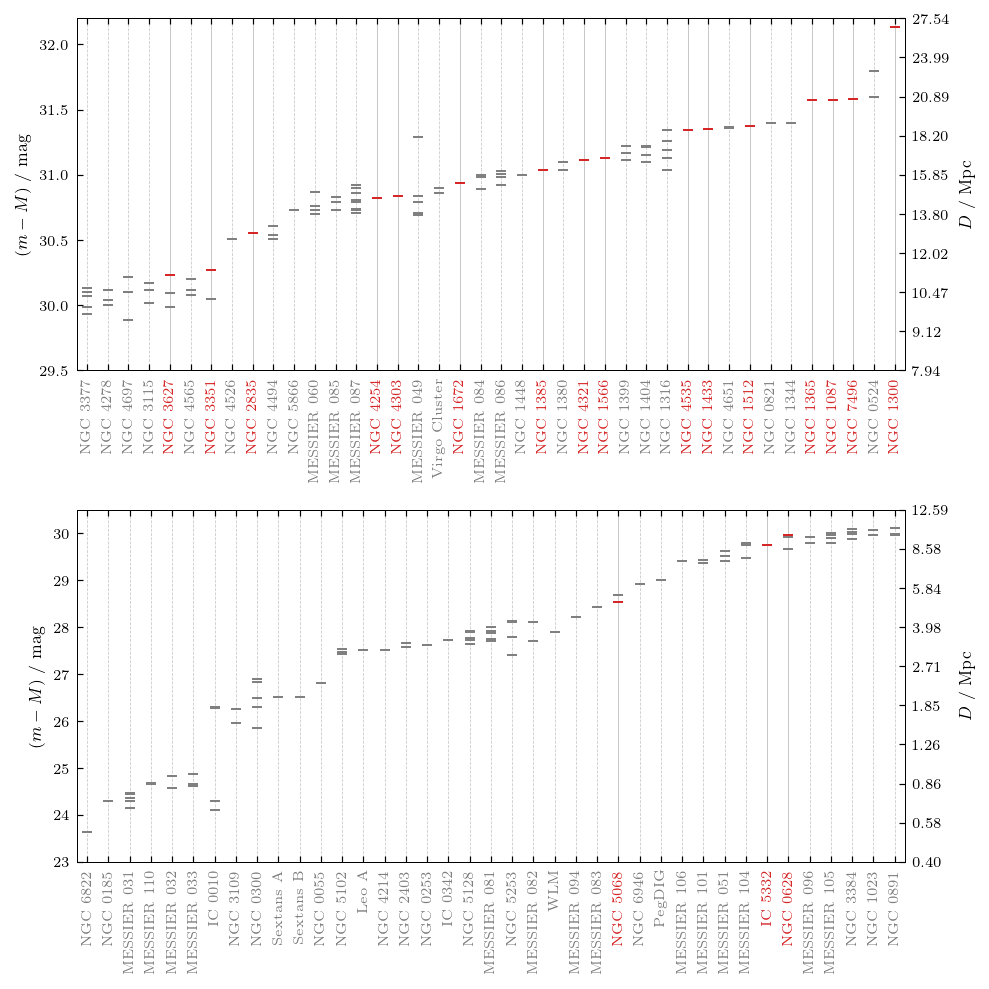

In [39]:

fig, (ax2,ax1) = plt.subplots(nrows=2,figsize=(two_column,two_column))

gal_names = [x for _,x in sorted(zip(mean_dis,galaxies))]

def literature_distances(labels,ax,ymin=23,ymax=32):
    
    # set the galaxy names as x-ticklabels
    ax.set(xticks=np.arange(1,len(labels)+1),
           ylabel='($m-M$) / mag',
           xlim=[0.5,len(labels)+0.5],
           ylim=[ymin,ymax])
    labels_new = [alias_back.get(l,l) for l in labels]
    ax.set_xticklabels(labels_new,rotation=90,color='gray')    
    ax.grid(axis='x',ls='--',lw=0.4)
    grid = ax.get_xgridlines()

    for i,label in enumerate(labels):
        tmp = pnlf_distances[pnlf_distances['name']==label]
        ax.scatter(len(tmp)*[i+1],tmp['m-M'],marker="_",color='gray')
        # color the measured by me red
        if len(tmp[tmp['REFCODE']=='Schmnn+2020'])>0:
            ax.get_xticklabels()[i].set(color="tab:red",fontweight='black')
            ax.scatter([i+1],tmp[tmp['REFCODE']=='Schmnn+2020']['m-M'],marker="_",color='tab:red')
            grid[i].set(ls='-',lw=0.5)
    
    
    yticks_mpc = np.logspace(np.log10(Distance(distmod=ymin).to(u.Mpc).value),np.log10(Distance(distmod=ymax).to(u.Mpc).value),10)
    yticks_mu  = Distance(yticks_mpc*u.Mpc).distmod

    axt = ax.twinx()
    axt.set_yticks(yticks_mu.value,minor=False)
    axt.set_yticklabels([f'{x:.2f}' for x in yticks_mpc],ha="left")
    axt.set(ylim=[ymin,ymax],ylabel='$D$ / Mpc')
    
    return ax
    
n = len(gal_names)
ax1 = literature_distances(gal_names[:int(n/2)],ax1,ymin=23,ymax=30.5)
ax2 = literature_distances(gal_names[int(n/2):],ax2,ymin=29.5,ymax=32.2)

#ax2.set_title('Galaxies with PNLF distances')
plt.tight_layout()


plt.savefig(basedir/'reports'/'PNstudies.pdf',dpi=600)
plt.savefig(basedir/'reports'/'PNstudies.png',dpi=600)

plt.show()

In [ ]:
from scipy.stats import mode

In [ ]:
def mode_only(array):
    m,c = mode(array)
    return m

## Compare with Deep

In [ ]:
deep   = ascii.read(basedir/'data'/'literature distances'/'deep_distances.csv')
result = ascii.read(basedir/'data'/'interim'/'PHANGS_PNLF_distances.txt')

deep.add_index("galaxy")
deep['d'] = [float(x[:-4]) for x in deep['distance']]
deep['e'] = [float(x[:-4]) for x in deep['error']]

In [ ]:
fig,ax = plt.subplots(figsize=(two_column,two_column/1.618))
result.sort('d/Mpc')
for i, row in enumerate(result):
    dm,dp = row['err-d/Mpc'],row['err+d/Mpc']
    ax.errorbar(i-0.1,row['d/Mpc'],yerr=([dm],[dp]),fmt='o',color='tab:red')
    
    tmp = deep.loc[row['name']]
    ax.errorbar(i+0.1,tmp['d'],yerr=tmp['e'],fmt='o',color='black')
    
ax.set(xticks=np.arange(0,len(result)),
       ylabel='$D$ / Mpc',
       title='PHANGS distances',
       xlim=[-0.5,len(result)-0.5])
ax.set_xticklabels(result['name'],rotation=90)  
ax.grid(axis='x')

legend_elements = [mpl.lines.Line2D([0], [0], color=col, lw=2, label=l) for col,l in zip(['tab:red','black'],['PNLF','TRGB'])]
plt.legend(handles=legend_elements, loc='lower center',ncol=10)
plt.savefig(basedir/'reports'/'PNLF_vs_TRGB.png',dpi=600)

plt.show()

## Plot entire sky

In [ ]:
filename = basedir / 'data' / 'catalogues' / 'sample.txt'
sample = ascii.read(filename,format='fixed_width_two_line',delimiter_pad=' ',position_char='=')
sample['SkyCoord'] = SkyCoord(sample['R.A.'],sample['Dec.'])

ra = sample['SkyCoord'].ra
ra = ra.wrap_at(180*u.degree)
dec = sample['SkyCoord'].dec

In [ ]:
#mpl.use('pdf')
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra.radian,dec.radian,marker='.')
#ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])

for x,y,s in zip(ra,dec,sample['Name']):
    ax.annotate(s,(x.radian,y.radian),xycoords='data',size='x-small')

fig.savefig("map.pdf")


## Angular resolution of all galaxies

In [ ]:
for name in results['name']:
    with fits.open(data_raw/'AUXILIARY'/'seeing_maps'/f'{name}_seeing.fits') as hdul:
        PSF = hdul[0].data
    
    res_min = np.nanmin(PSF)/206265*results.loc[name]['d/Mpc']*1e6
    res_max = np.nanmax(PSF)/206265*results.loc[name]['d/Mpc']*1e6
    
    ang_min = np.nanmin(PSF)
    ang_max = np.nanmax(PSF)
    
    print(f'{name}: min={ang_min:.2f} pc, max={ang_max:.2f} pc')

## Misc

In [ ]:
from pnlf.auxiliary import mu_to_parsec, parsec_to_mu

In [ ]:
d = 18.72
mu,mu_err = parsec_to_mu(d*u.Mpc,0.15*d*u.Mpc)
print(f'{mu.value:.2f},{mu_err[0]:.2f},{d:.2f},NAM,2020AJ....159...67K,,,,,')

In [ ]:
d,derr= 17.22, 2.58 
mu,mu_err = parsec_to_mu( d*u.Mpc,derr*u.Mpc)
print(f'{mu.value:.2f},{mu_err[0]:.2f},{d:.2f}')

In [ ]:
trgb['(m-M)'], trgb['err(m-M)'] = parsec_to_mu(trgb['Distance']*u.Mpc,trgb['Error']*u.Mpc)

In [ ]:
trgb = ascii.read(basedir/'data'/'literature distances'/'PHANGSDistancesJuly23.txt',format='csv',delimiter='&')

In [ ]:
catalogues = {}
for name in results['name']:
    filename = basedir / 'data' / 'catalogues' / f'{name}_nebulae.txt'
    catalogues[name] = ascii.read(filename,format='fixed_width_two_line',delimiter_pad=' ',position_char='=')

In [ ]:
from pnlf.analyse import MaximumLikelihood1D, PNLF, pnlf
from pnlf.plot.pnlf import plot_pnlf
from pnlf.auxiliary import mu_to_parsec

name = 'NGC1385'

param = parameters[name]
cl = param['completeness_limit']
tbl = catalogues[name]
if False:
    data = tbl[((tbl['type']=='PN') | (tbl['SNRorPN']=='True')) & (tbl['exclude']==0)]['mOIII']
    err = tbl[((tbl['type']=='PN') | (tbl['SNRorPN']=='True')) & (tbl['exclude']==0)]['dmOIII']
else:
    data = tbl[(tbl['type']=='PN') & (tbl['exclude']==0) & (tbl['v_SIGMA']<1000) ]['mOIII']
    err  = tbl[(tbl['type']=='PN') & (tbl['exclude']==0)]['dmOIII']

fitter = MaximumLikelihood1D(pnlf,data[data<cl],mhigh=cl,Mmax=-4.47)
mu,mu_p,mu_m = fitter([28])
mu_p = np.sqrt(mu_p**2+np.nanmean(err)**2+dPSF**2)
mu_m = np.sqrt(mu_m**2+np.nanmean(err)**2+dPSF**2)
d,(dp,dm)=mu_to_parsec(mu,[mu_p,mu_m])
print('{:.2f} + {:.2f} - {:.2f}'.format(d,dp,dm))
print('{:.2f} + {:.2f} - {:.2f}'.format(mu,mu_p,mu_m))

#Plot PNLF
axes = plot_pnlf(data,
                 mu,
                 cl,
                 binsize=param['binsize'],
                 #mhigh=29,
                 filename=None,
                 color=tab10[0])


In [ ]:
tmp = tbl[(tbl['type']=='PN') & (tbl['mOIII']<29) & (tbl['exclude']==0)]
tmp.sort('mOIII')

plt.scatter(tmp['mOIII'],tmp['v_SIGMA'])
plt.axvline(np.min(tmp['mOIII'])+1)
plt.show()

In [ ]:
from pnlf.io import ReadLineMaps
galaxy = ReadLineMaps(data_raw,name,**parameters[name])


In [ ]:
from pnlf.plot.plot import plot_sky_with_detected_stars
tmp = tbl[tbl['exclude']==1]
positions = np.transpose((tmp['x'], tmp['y']))

plot_sky_with_detected_stars(data=galaxy.OIII5006_DAP,
                             wcs=galaxy.wcs,
                             positions=positions
                             )